In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gzip
import torch
import sys

sys.path.append("..")
from functions.prompts import Prompt
from functions.modified_predictor import modifiedPredictor
from functions.pipeline import *

from torchmetrics.classification import (
    BinaryF1Score,
    BinaryAccuracy,
    BinaryJaccardIndex,
)

# Analyze the results from the error sampling experiment

## Load the data from the one sampled point experiment and the error sampling experiments

In [9]:
df_1_point = pd.read_csv(
    "/Users/lisa/Documents/Master/sam-lab/lisa/results/pos_0100.csv"
)
df_1_point.head()

,image_id,f_points_class_1,f_points_class_2,f_points_class_3,b_points_class_1,b_points_class_2,b_points_class_3,dice_class_1,dice_class_2,dice_class_3,IOU_class_1,IOU_class_2,IOU_class_3,accuracy_class_1,accuracy_class_2,accuracy_class_3
0,0,1,1,1,0,0,0,0.064,0.267,0.329,0.033,0.154,0.197,0.958,0.942,0.979
1,0,1,1,1,0,0,0,0.859,0.444,0.000,0.753,0.285,0.000,0.991,0.966,0.973
2,0,1,1,1,0,0,0,0.813,0.459,0.000,0.685,0.298,0.000,0.987,0.969,0.973
3,0,1,1,1,0,0,0,0.815,0.473,0.000,0.688,0.310,0.000,0.987,0.970,0.973
4,0,1,1,1,0,0,0,0.783,0.429,0.000,0.644,0.273,0.000,0.984,0.968,0.973


In [10]:
len(df_1_point)

142100

In [11]:
df_error_sampling = pd.read_csv(
    "/Users/lisa/Documents/Master/sam-lab/lisa/results/error_sampling_0.csv"
)
df_error_sampling.head()

,image_id,f_points_class_1,f_points_class_2,f_points_class_3,b_points_class_1,b_points_class_2,b_points_class_3,dice_class_1,dice_class_2,dice_class_3,IOU_class_1,IOU_class_2,IOU_class_3,accuracy_class_1,accuracy_class_2,accuracy_class_3
0,0,2,2,2,0,0,0,0.854,0.476,0.09,0.746,0.313,0.047,0.990,0.969,0.975
1,0,2,2,2,0,0,0,0.800,0.438,0.00,0.667,0.281,0.000,0.986,0.970,0.973
2,0,2,2,2,0,0,0,0.851,0.449,0.00,0.740,0.289,0.000,0.990,0.965,0.973
3,0,2,2,2,0,0,0,0.845,0.462,0.00,0.732,0.301,0.000,0.990,0.967,0.973
4,0,2,2,2,0,0,0,0.820,0.453,0.00,0.695,0.293,0.000,0.988,0.969,0.973


In [12]:
len(df_error_sampling)

35000

## Combine both dataframes by inserting the rows from the one point sampling into the error sampling dataframe

In [13]:
n_images = 50  # max(df_1_point["image_id"])
batch_size = 50
max_n_points_per_class = 15
df = df_error_sampling.copy()  # create copy to make a new combined dataframe
for image_id in tqdm(range(n_images)):
    index_insert = (
        image_id * batch_size * max_n_points_per_class
    )  # index of start of results for one image
    rows_to_insert = df_1_point[50 * image_id : 50 * image_id + 50]
    df = pd.concat(
        [df.iloc[:index_insert], rows_to_insert, df.iloc[index_insert:]]
    ).reset_index(drop=True)

Python(15335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 50/50 [00:00<00:00, 670.16it/s]


The labeling of points is not correct in the 1-point dataframe, because it was not implemented when doing the experiment to assert the nature of the label. All points are counted as foreground.

To make the count of points correct, I change the label to background, if after sampling from the error map, both points of a class are labeled background. This tells me, that the first point also has to be background.

In [14]:
df.iloc[8 * 50 * 15 + 0]

image_id            8.000
f_points_class_1    1.000
f_points_class_2    1.000
f_points_class_3    1.000
b_points_class_1    0.000
b_points_class_2    0.000
b_points_class_3    0.000
dice_class_1        0.000
dice_class_2        0.706
dice_class_3        0.783
IOU_class_1         0.000
IOU_class_2         0.545
IOU_class_3         0.644
accuracy_class_1    0.966
accuracy_class_2    0.998
accuracy_class_3    0.999
Name: 6000, dtype: float64

In [15]:
for image_id in tqdm(range(n_images)):
    for batch_entry in range(batch_size):
        # check all 3 classes
        for label in [1, 2, 3]:
            if (
                df.iloc[image_id * 50 * 15 + batch_entry + 50][
                    f"b_points_class_{label}"
                ]
                == 2
            ):  # check if both points are background
                df.loc[image_id * 50 * 15 + batch_entry, f"b_points_class_{label}"] = (
                    1  # change label of the single point
                )
                df.loc[image_id * 50 * 15 + batch_entry, f"f_points_class_{label}"] = 0

100%|██████████| 50/50 [00:00<00:00, 377.93it/s]


Check if label for class 1 got changed in image where I know there is no class 1 segmentation

In [16]:
df.iloc[8 * 50 * 15 + 0]

image_id            8.000
f_points_class_1    0.000
f_points_class_2    1.000
f_points_class_3    1.000
b_points_class_1    1.000
b_points_class_2    0.000
b_points_class_3    0.000
dice_class_1        0.000
dice_class_2        0.706
dice_class_3        0.783
IOU_class_1         0.000
IOU_class_2         0.545
IOU_class_3         0.644
accuracy_class_1    0.966
accuracy_class_2    0.998
accuracy_class_3    0.999
Name: 6000, dtype: float64

### save in a file

In [17]:
df.to_csv(
    "/Users/lisa/Documents/Master/sam-lab/lisa/results/first_batch_df.csv", index=False
)

## start with analysis

In [18]:
df = pd.read_csv("/Users/lisa/Documents/Master/sam-lab/lisa/results/first_batch_df.csv")
df.head(10)

,image_id,f_points_class_1,f_points_class_2,f_points_class_3,b_points_class_1,b_points_class_2,b_points_class_3,dice_class_1,dice_class_2,dice_class_3,IOU_class_1,IOU_class_2,IOU_class_3,accuracy_class_1,accuracy_class_2,accuracy_class_3
0,0,1,1,1,0,0,0,0.064,0.267,0.329,0.033,0.154,0.197,0.958,0.942,0.979
1,0,1,1,1,0,0,0,0.859,0.444,0.000,0.753,0.285,0.000,0.991,0.966,0.973
2,0,1,1,1,0,0,0,0.813,0.459,0.000,0.685,0.298,0.000,0.987,0.969,0.973
3,0,1,1,1,0,0,0,0.815,0.473,0.000,0.688,0.310,0.000,0.987,0.970,0.973
4,0,1,1,1,0,0,0,0.783,0.429,0.000,0.644,0.273,0.000,0.984,0.968,0.973
5,0,1,1,1,0,0,0,0.772,0.425,0.000,0.629,0.270,0.000,0.983,0.969,0.973
6,0,1,1,1,0,0,0,0.804,0.398,0.000,0.672,0.249,0.000,0.986,0.966,0.973
7,0,1,1,1,0,0,0,0.834,0.473,0.000,0.715,0.309,0.000,0.989,0.969,0.973
8,0,1,1,1,0,0,0,0.778,0.403,0.000,0.637,0.252,0.000,0.984,0.966,0.973
9,0,1,1,1,0,0,0,0.838,0.467,0.000,0.722,0.304,0.000,0.989,0.968,0.973


## Plot 1: Prompt development for exemplary images

In [19]:
n_points = list(range(1, 16))
image_id = 3
image_df = df[df["image_id"] == image_id]
image_df = image_df.reset_index(drop=True)
image_df

,image_id,f_points_class_1,f_points_class_2,f_points_class_3,b_points_class_1,b_points_class_2,b_points_class_3,dice_class_1,dice_class_2,dice_class_3,IOU_class_1,IOU_class_2,IOU_class_3,accuracy_class_1,accuracy_class_2,accuracy_class_3
0,3,1,1,1,0,0,0,0.000,0.044,0.000,0.000,0.023,0.000,0.972,0.363,0.970
1,3,1,1,1,0,0,0,0.257,0.023,0.740,0.147,0.012,0.587,0.922,0.407,0.988
2,3,1,1,1,0,0,0,0.000,0.045,0.000,0.000,0.023,0.000,0.934,0.373,0.970
3,3,1,1,1,0,0,0,0.119,0.004,0.820,0.063,0.002,0.695,0.801,0.540,0.991
4,3,1,1,1,0,0,0,0.045,0.045,0.006,0.023,0.023,0.003,0.957,0.375,0.970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,3,10,15,15,5,0,0,0.889,0.706,0.883,0.800,0.546,0.790,0.997,0.988,0.994
746,3,13,15,15,2,0,0,0.836,0.725,0.908,0.719,0.568,0.832,0.995,0.990,0.995
747,3,12,15,15,3,0,0,0.857,0.790,0.936,0.750,0.653,0.879,0.996,0.992,0.996
748,3,9,14,15,6,1,0,0.894,0.740,0.969,0.808,0.588,0.940,0.997,0.990,0.998


Create dictionaries with the scores for 50 runs in 1 image. The resukts are stored in a list of lists for each label in the dictionary.
The entries in the outer list are the different runs and one entry in the inner lists is the result value for a specific number of points in the prompt per label (1-15).

In [20]:
dice_scores = {1: [], 2: [], 3: []}
IOU_scores = {1: [], 2: [], 3: []}
for batch_entry in range(batch_size):
    for label in [1, 2, 3]:
        label_scores_dice = []
        label_scores_IOU = []
        for n in n_points:
            index = (n - 1) * batch_size + batch_entry

            label_scores_dice.append(image_df.loc[index, f"dice_class_{label}"])
            label_scores_IOU.append(image_df.loc[index, f"IOU_class_{label}"])
        dice_scores[label].append(label_scores_dice)
        IOU_scores[label].append(label_scores_IOU)

### Dice Score

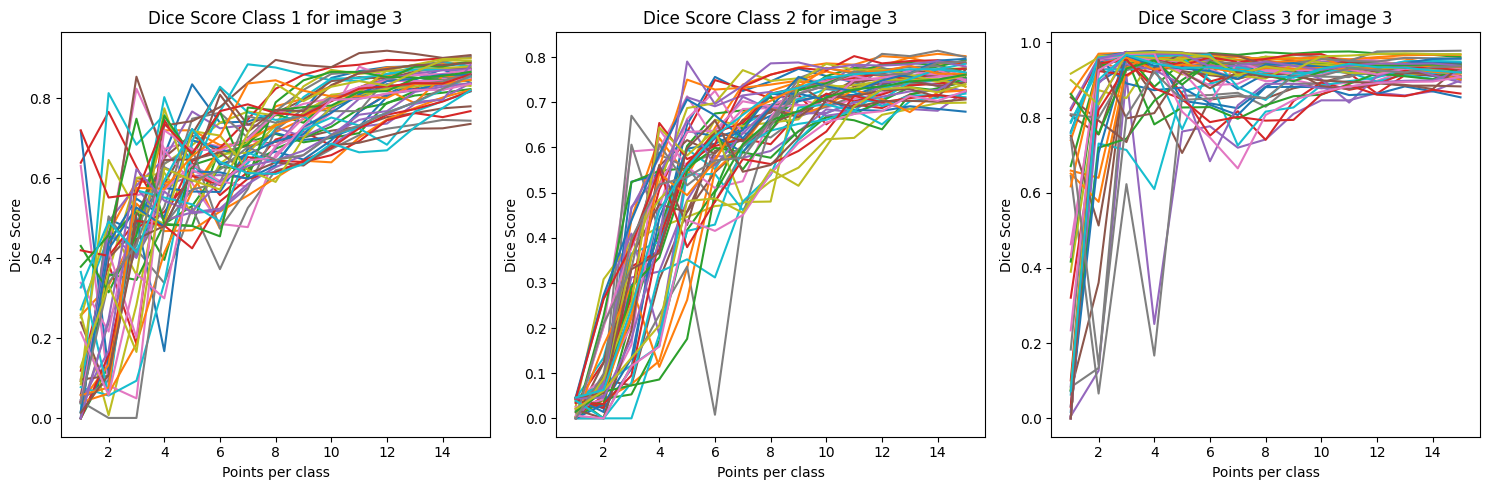

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate([1, 2, 3]):
    ax = axes[i]
    for j, line in enumerate(dice_scores[label]):
        ax.plot(range(1, 16), line, label=f"Line {j+1}")

    ax.set_xlabel("Points per class")
    ax.set_ylabel("Dice Score")
    ax.set_title(f"Dice Score Class {label} for image {image_id}")


plt.tight_layout()
plt.show()

Calculate mean scores between the classes

In [22]:
dice_means = []
for run in range(batch_size):
    run_means = []
    for n in range(15):
        result = 0
        for label in [1, 2, 3]:
            result += dice_scores[label][run][n]
        run_means.append(result / 3)
    dice_means.append(run_means)

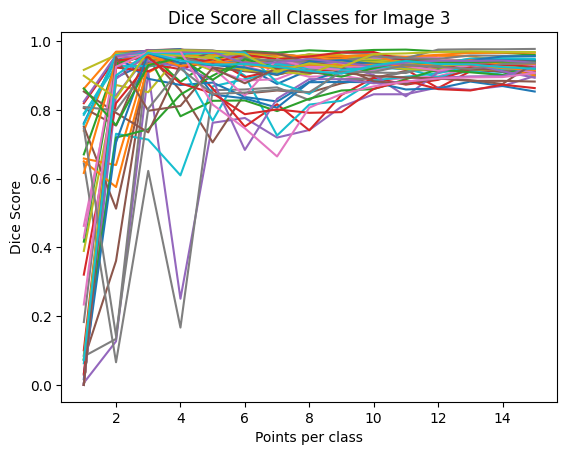

In [23]:
for j, line in enumerate(dice_scores[label]):
    plt.plot(range(1, 16), line, label=f"Line {j+1}")

# Add labels and legend
plt.xlabel("Points per class")
plt.ylabel("Dice Score")
plt.title(f"Dice Score all Classes for Image {image_id}")

# Show the plot
plt.show()

### IOU Score

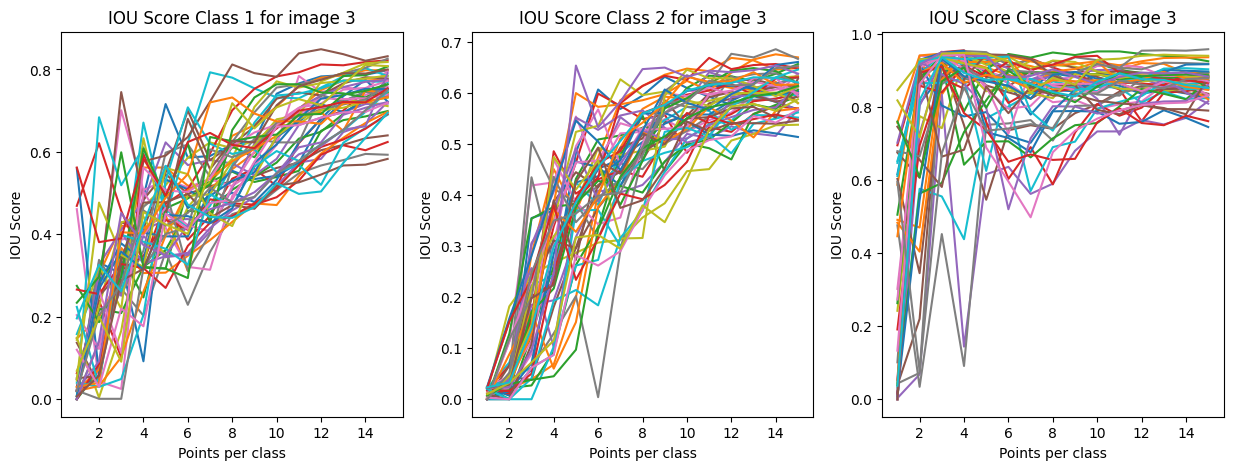

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate([1, 2, 3]):
    ax = axes[i]
    for j, line in enumerate(IOU_scores[label]):
        ax.plot(range(1, 16), line, label=f"Line {j+1}")

    ax.set_xlabel("Points per class")
    ax.set_ylabel("IOU Score")
    ax.set_title(f"IOU Score Class {label} for image {image_id}")

In [25]:
IOU_means = []
for run in range(batch_size):
    run_means = []
    for n in range(15):
        result = 0
        for label in [1, 2, 3]:
            result += IOU_scores[label][run][n]
        run_means.append(result / 3)
    IOU_means.append(run_means)

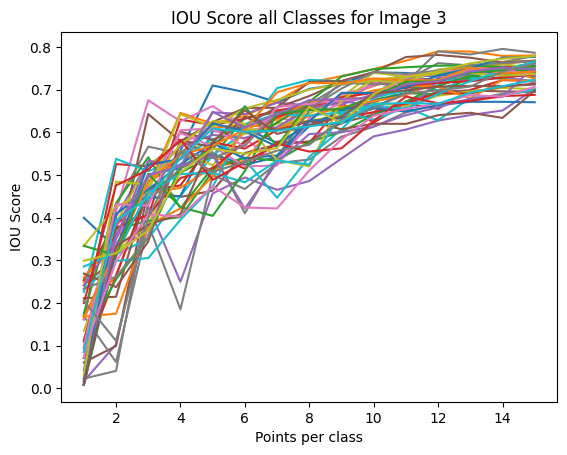

In [26]:
for j, line in enumerate(IOU_means):
    plt.plot(range(1, 16), line, label=f"Line {j+1}")

# Add labels and legend
plt.xlabel("Points per class")
plt.ylabel("IOU Score")
plt.title(f"IOU Score all Classes for Image {image_id}")

# Show the plot
plt.show()

## Plot 2 - statistics on the results for the complete dataset

For a class only include results from images that really contain this class

In [27]:
with gzip.open(
    "/Users/lisa/Documents/Master/sam-lab/ACDC/ground_truth.npy.gz", "rb"
) as f:
    # Load the NumPy array from the file
    ground_truths = np.load(f)

In [28]:
def get_class_list(class_num, ground_truth):
    array1 = np.any(ground_truth == class_num, axis=1)
    array2 = np.any(array1 == True, axis=1)
    class_indices = np.where(array2 == True)
    indices = list(class_indices[0])
    return indices

In [29]:
class_indices = {}
for c in [1, 2, 3]:
    class_indices[c] = get_class_list(c, ground_truths)

In [30]:
dice = {"mean": {1: [], 2: [], 3: []}, "std": {1: [], 2: [], 3: []}}
IOU = {"mean": {1: [], 2: [], 3: []}, "std": {1: [], 2: [], 3: []}}

# for every number of points load the results for the complete dataset
for n in range(1, 16):
    for label in [1, 2, 3]:
        df_n_points = df[
            (df["f_points_class_1"] + df["b_points_class_1"] == n)
            & df["image_id"].isin(class_indices[label])
        ]
        dice["mean"][label].append(df_n_points[f"dice_class_{label}"].mean())
        dice["std"][label].append(df_n_points[f"dice_class_{label}"].std())

        IOU["mean"][label].append(df_n_points[f"IOU_class_{label}"].mean())
        IOU["std"][label].append(df_n_points[f"IOU_class_{label}"].std())

### Dice

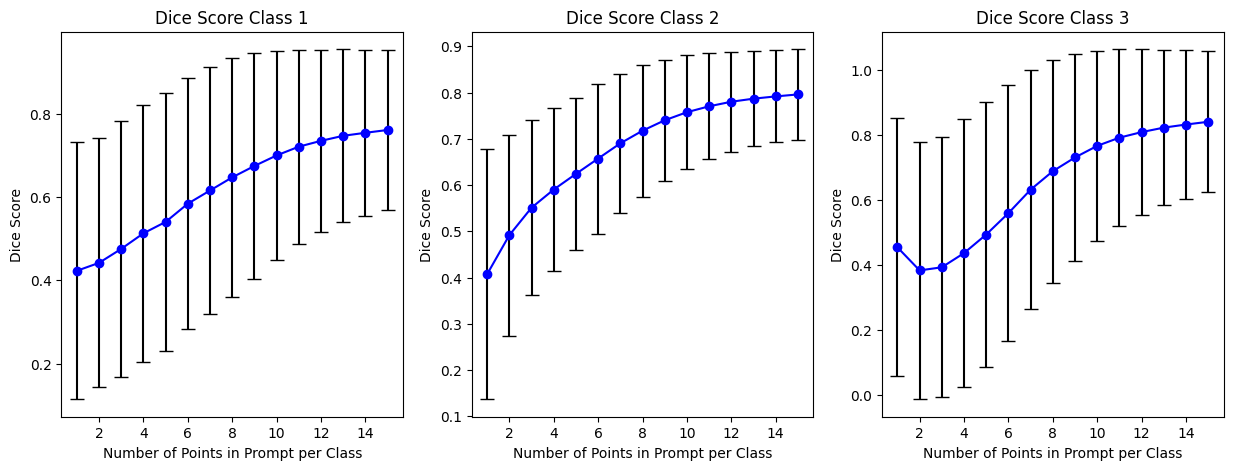

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate([1, 2, 3]):
    ax = axes[i]
    ax.errorbar(
        range(1, 16),
        dice["mean"][label],
        yerr=dice["std"][label],
        capsize=5,
        fmt="-o",
        color="blue",
        ecolor="black",
    )

    ax.set_xlabel("Number of Points in Prompt per Class")
    ax.set_ylabel("Dice Score")
    ax.set_title(f"Dice Score Class {label}")


plt.show()

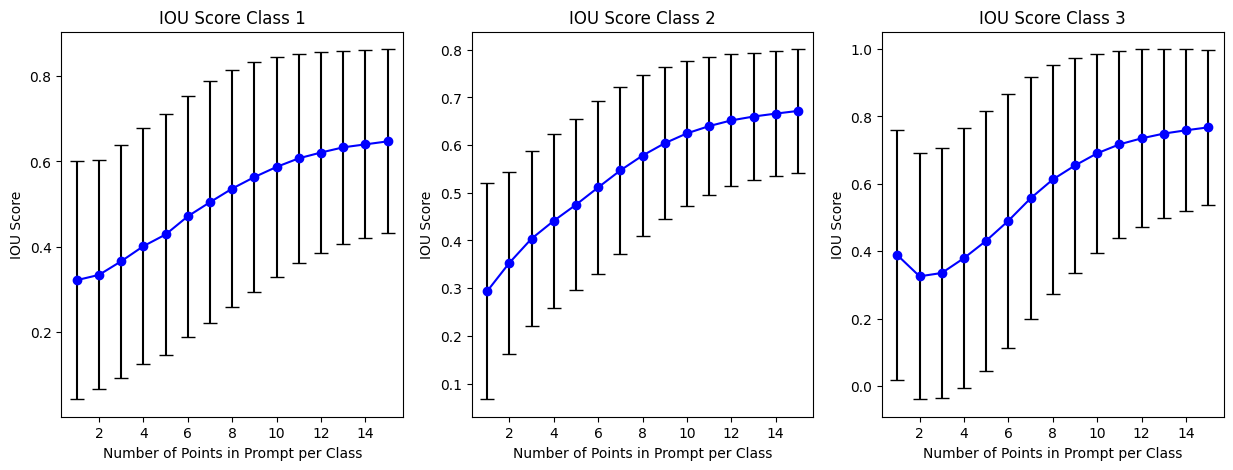

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate([1, 2, 3]):
    ax = axes[i]
    ax.errorbar(
        range(1, 16),
        IOU["mean"][label],
        yerr=IOU["std"][label],
        capsize=5,
        fmt="-o",
        color="blue",
        ecolor="black",
    )

    ax.set_xlabel("Number of Points in Prompt per Class")
    ax.set_ylabel("IOU Score")
    ax.set_title(f"IOU Score Class {label}")

plt.show()

## Plot 3 - qualitative Analysis, show segmentations and which point gets sampled from error map

In [2]:
with gzip.open(
    "/Users/lisa/Documents/Master/sam-lab/ACDC/ground_truth.npy.gz", "rb"
) as f:
    # Load the NumPy array from the file
    ground_truths = np.load(f)

In [3]:
embeddings = torch.load("/Users/lisa/Documents/Master/sam-lab/ACDC/embeddings.pt")

In [4]:
with gzip.open("/Users/lisa/Documents/Master/sam-lab/ACDC/images.npy.gz", "rb") as f:
    # Load the NumPy array from the file
    images = np.load(f)

(tensor([[[116,  63]]]), tensor([[1]]))
(tensor([[[116,  63],
         [129, 183]]]), tensor([[1, 0]]))
(tensor([[[116,  63],
         [105, 180],
         [129, 183]]]), tensor([[1, 0, 0]]))


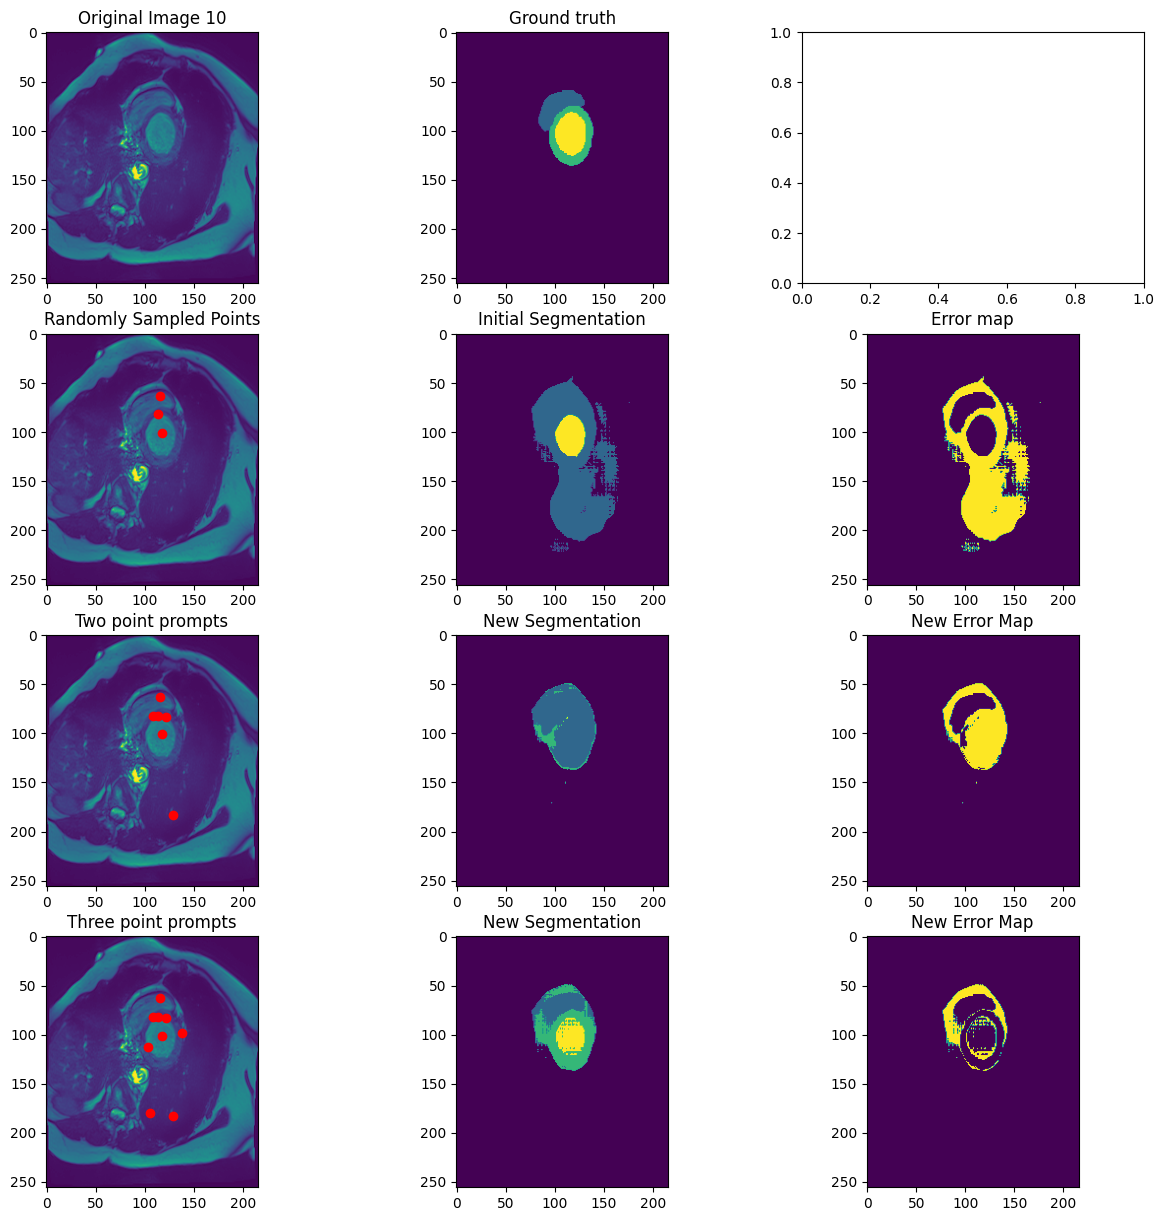

In [7]:
image_id = 10
ground_truth = torch.tensor(ground_truths[image_id])
embedding = embeddings[image_id]
image = images[image_id]

# plot image and ground truth
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

ax = axes[0, 0]
ax.imshow(image)
ax.set_title(f"Original Image {image_id}")

ax = axes[0, 1]
ax.imshow(ground_truth)
ax.set_title("Ground truth")

# make initial random 1 point sampled prompt
rand_prompt_1 = batch_sample_from_class(1, ground_truth, 1, 1)
rand_prompt_2 = batch_sample_from_class(1, ground_truth, 2, 1)
rand_prompt_3 = batch_sample_from_class(1, ground_truth, 3, 1)
print(rand_prompt_1)
# compute initial segmentation mask
mp = modifiedPredictor()

logit_class_1 = mp.predict(embedding, rand_prompt_1[0], rand_prompt_1[1])
logit_class_2 = mp.predict(embedding, rand_prompt_2[0], rand_prompt_2[1])
logit_class_3 = mp.predict(embedding, rand_prompt_3[0], rand_prompt_3[1])

logit_stack = torch.cat([logit_class_1, logit_class_2, logit_class_3], dim=1)
mask = multiclass_prob_batched(logit_stack, hard_labels=True)
# plot sampled points over image, sam segmentation and error map
ax = axes[1, 0]
ax.imshow(image)


for i, label_prompt in enumerate([rand_prompt_1, rand_prompt_2, rand_prompt_3]):
    point = label_prompt[0].squeeze()
    # first points
    x = point[0]
    y = point[1]
    ax.scatter(x, y, color="red")
ax.set_title("Randomly Sampled Points")

ax = axes[1, 1]
ax.imshow(mask.squeeze())
ax.set_title("Initial Segmentation")

error_map = mask != ground_truth
ax = axes[1, 2]
ax.imshow(error_map.squeeze())
ax.set_title("Error map")

# compute scores

# sample next points from error map
pr1 = Prompt(1, ground_truth, rand_prompt_1[0], rand_prompt_1[1])
pr1.give_masks(mask)
pr2 = Prompt(2, ground_truth, rand_prompt_2[0], rand_prompt_2[1])
pr2.give_masks(mask)
pr3 = Prompt(3, ground_truth, rand_prompt_3[0], rand_prompt_3[1])
pr3.give_masks(mask)

pr1.add_point_to_prompts()
pr2.add_point_to_prompts()
pr3.add_point_to_prompts()

pr1_sam = pr1.get_prompts_sam()
pr2_sam = pr2.get_prompts_sam()
pr3_sam = pr3.get_prompts_sam()

# generate next segmentation
# give prompts to the predictor and generate multiclass masks
logit_class_1 = mp.predict(embedding, pr1_sam[0], pr1_sam[1])
logit_class_2 = mp.predict(embedding, pr2_sam[0], pr2_sam[1])
logit_class_3 = mp.predict(embedding, pr3_sam[0], pr3_sam[1])

logit_stack = torch.cat([logit_class_1, logit_class_2, logit_class_3], dim=1)
new_mask = multiclass_prob_batched(logit_stack, hard_labels=True)

# generate next error map
new_error_map = new_mask != ground_truth

# compute scores

# plot sampled points over image, sam segmentation and error map
ax = axes[2, 0]
ax.imshow(image)

for i, label_prompt in enumerate([pr1_sam, pr2_sam, pr3_sam]):
    points = label_prompt[0].squeeze()
    # second point
    x = points[0, 0]
    y = points[0, 1]

    ax.scatter(x, y, color="red")
    # first point
    x = points[1, 0]
    y = points[1, 1]
    ax.scatter(x, y, color="red")
ax.set_title("Two point prompts")

ax = axes[2, 1]
ax.imshow(new_mask.squeeze())
ax.set_title("New Segmentation")

ax = axes[2, 2]
ax.imshow(new_error_map.squeeze())
ax.set_title("New Error Map")

# make 3 point prompt
pr1.add_point_to_prompts()
pr2.add_point_to_prompts()
pr3.add_point_to_prompts()

pr1_sam = pr1.get_prompts_sam()
pr2_sam = pr2.get_prompts_sam()
pr3_sam = pr3.get_prompts_sam()

# generate next segmentation
# give prompts to the predictor and generate multiclass masks
logit_class_1 = mp.predict(embedding, pr1_sam[0], pr1_sam[1])
logit_class_2 = mp.predict(embedding, pr2_sam[0], pr2_sam[1])
logit_class_3 = mp.predict(embedding, pr3_sam[0], pr3_sam[1])

logit_stack = torch.cat([logit_class_1, logit_class_2, logit_class_3], dim=1)
new_mask = multiclass_prob_batched(logit_stack, hard_labels=True)

# generate next error map
new_error_map = new_mask != ground_truth

# compute scores

# plot sampled points over image, sam segmentation and error map
ax = axes[3, 0]
ax.imshow(image)

for i, label_prompt in enumerate([pr1_sam, pr2_sam, pr3_sam]):
    points = label_prompt[0].squeeze()
    # third points
    x = points[0, 0]
    y = points[0, 1]
    ax.scatter(x, y, color="red")
    # second points
    x = points[1, 0]
    y = points[1, 1]
    ax.scatter(x, y, color="red")
    # first points
    x = points[2, 0]
    y = points[2, 1]
    ax.scatter(x, y, color="red")


ax.set_title("Three point prompts")
ax = axes[3, 1]
ax.imshow(new_mask.squeeze())
ax.set_title("New Segmentation")

ax = axes[3, 2]
ax.imshow(new_error_map.squeeze())
ax.set_title("New Error Map")

plt.show()